In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import plotly.express as px
from itertools import product
import time
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Save Results

## Load mlflow runs

In [2]:
db_port = 5001
db_name = 'recursive_clustering'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
results_dir = Path('/home/bbelucci/code/recursive_clustering/results/processed_results')
os.makedirs(results_dir, exist_ok=True)

In [3]:
experiment_names

['Default',
 'blob_experiment',
 'hpo_classif_experiment',
 'hpo_openml_experiment',
 'hpo_gaussian_experiment',
 'hpo_openml_final',
 'outlier_hc',
 'time_hc',
 'hpo_n_clusters',
 'hpo_classif_huge']

In [4]:
experiments_names = [
    'time_hc',
]

In [5]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'n_random',
    'n_informative',
    'n_classes',
    'model_params/representative_method'
]

In [6]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity_completeness_v_measure',
    'silhouette',
    # 'best_n_clusters_',
    # 'best_rand_score',
    # 'best_adjusted_rand',
    # 'best_mutual_info',
    # 'best_adjusted_mutual_info',
    # 'best_normalized_mutual_info',
    # 'best_homogeneity_completeness_v_measure',
    # 'best_silhouette',
]

In [7]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    # 'parent_run_id',
    # 'best_child_run_id',
]

In [8]:
# parameters of each model, they are saved as tags for the parent run
parameters = {
    'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
    'KMeans': ['n_clusters'],
    'HDBSCAN': ['min_cluster_size'],
    'DBSCAN': ['eps', 'min_samples'],
    'AffinityPropagation': ['damping'],
    'OPTICS': ['min_samples'],
    'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
    'WardAgglomerativeClustering': ['n_clusters'],
}
all_model_parameters = [p for model, params in parameters.items() for p in params]
all_model_parameters = list(set(all_model_parameters))
for param in all_model_parameters:
    tags_columns.append(param)

In [9]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [10]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)
df_runs_raw['model_params/representative_method'] = df_runs_raw['model_params/representative_method'].fillna('')
df_runs_raw.loc[df_runs_raw['model_nickname']=='RecursiveClustering', 'model_nickname'] = df_runs_raw.loc[df_runs_raw['model_nickname']=='RecursiveClustering', 'model_nickname'] + '_' + df_runs_raw.loc[df_runs_raw['model_nickname']=='RecursiveClustering', 'model_params/representative_method']

## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [11]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
    'n_random',
    'n_informative',
    'n_classes',
    'model_params/representative_method'
]
df_runs = df_runs_raw.dropna(axis=0, how='all', subset=['adjusted_rand']).copy()
df_runs = df_runs.loc[(~df_runs.duplicated(non_duplicate_columns))]

In [12]:
no_run_time = np.inf
df_runs_timed_out = df_runs_raw.copy()
df_runs_timed_out = df_runs_timed_out.loc[df_runs_timed_out.EXCEPTION == 'FunctionTimedOut']
df_runs_timed_out = df_runs_timed_out.loc[(~df_runs_timed_out.duplicated(non_duplicate_columns))]
df_runs_timed_out['fit_model_return_elapsed_time'] = no_run_time
df_runs = pd.concat([df_runs, df_runs_timed_out])

In [13]:
status = 'FAILED'
no_run_memory = np.inf
raised_exception = True
EXCEPTION = 'NoRun'
start_time = time.time() * 1000
end_time = time.time() * 1000
no_run_time = np.inf

In [14]:
# HDBSCAN do not run with (14427,14427), (14427,50000), and n_samples = 50000 n_features > 347
model_nickname = 'HDBSCAN'
n_samples = ['50000']
n_features = ['347', '1202', '4163', '14427', '50000']
seed_unified = [f'{i}' for i in range(10)]
pct_random = ['0.0']
class_sep = ['50.0']
combinations = list(product(n_samples, n_features, seed_unified, pct_random, class_sep))
combinations_samples_features = [('14427', '14427'), ('14427', '50000')]
for samples, features in combinations_samples_features:
    combinations += list(product([samples], [features], seed_unified, pct_random, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, seed, pct, sep in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct
    df['seed_unified'] = seed
    df['class_sep'] = sep
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

In [15]:
# SpectralSubspaceRandomization do not run with n_samples > 50000
model_nickname = 'SpectralSubspaceRandomization'
n_samples = ['50000']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
seed_unified = [f'{i}' for i in range(10)]
pct_random = ['0.0']
class_sep = ['50.0']
combinations = list(product(n_samples, n_features, seed_unified, pct_random, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, seed, pct, sep in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct
    df['seed_unified'] = seed
    df['class_sep'] = sep
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

In [16]:
# IRFLLRR do not run with n_samples > 14427
model_nickname = 'IRFLLRR'
n_samples = ['14427', '50000']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
seed_unified = [f'{i}' for i in range(10)]
pct_random = ['0.0']
class_sep = ['50.0']
combinations = list(product(n_samples, n_features, seed_unified, pct_random, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, seed, pct, sep in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct
    df['seed_unified'] = seed
    df['class_sep'] = sep
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

In [17]:
# KMeansProj do not run with (14427,14427), (14427,50000), (50000,14427), (50000,50000)
model_nickname = 'KMeansProj'
n_samples = ['14427', '50000']
n_features = ['14427', '50000']
seed_unified = [f'{i}' for i in range(10)]
pct_random = ['0.0']
class_sep = ['50.0']
combinations = list(product(n_samples, n_features, seed_unified, pct_random, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, seed, pct, sep in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct
    df['seed_unified'] = seed
    df['class_sep'] = sep
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

In [18]:
# SingleAgglomerativeClustering do not run with (14427,14427), (14427,50000), (50000,14427), (50000,50000)
model_nickname = 'SingleAgglomerativeClustering'
n_samples = ['14427', '50000']
n_features = ['14427', '50000']
seed_unified = [f'{i}' for i in range(10)]
pct_random = ['0.0']
class_sep = ['50.0']
combinations = list(product(n_samples, n_features, seed_unified, pct_random, class_sep))
df_cat = []
indexes = []
for n_sample, n_feature, seed, pct, sep in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['pct_random'] = pct
    df['seed_unified'] = seed
    df['class_sep'] = sep
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

# Missing

In [19]:
df_runs['model_nickname'].unique().tolist()

['WardAgglomerativeClustering',
 'HDBSCAN',
 'DBSCAN',
 'SpectralClustering',
 'RecursiveClustering_',
 'AverageAgglomerativeClustering',
 'KMeans',
 'Proclus',
 'SpectralSubspaceRandomization',
 'AffinityPropagation',
 'OPTICS',
 'RecursiveClustering_closest_overall_1000',
 'CompleteAgglomerativeClustering',
 'SingleAgglomerativeClustering',
 'IRFLLRR',
 'Clique',
 'KMeansProj']

In [20]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'pct_random',
    'seed_unified',
    'class_sep',
]

In [21]:
# n_samples = ['100', '1000', '10000']
# n_features = ['100', '1000', '10000']
# pct_random = ['0.0', '0.2', '0.5', '0.7']
# seed_unified = [f'{i}' for i in range(10)]
# class_sep = ['10.0', '50.0', '100.0']
n_samples = ['100', '347', '1202', '4163', '14427', '50000']
n_features = ['14427']
pct_random = ['0.0']
seed_unified = [f'{i}' for i in range(10)]
class_sep = ['50.0']
model_nickname = [
    'WardAgglomerativeClustering',
    'KMeans',
    'DBSCAN',
    'HDBSCAN',
    'SpectralSubspaceRandomization',
    'RecursiveClustering_',
    'RecursiveClustering_closest_overall_1000',
    'OPTICS',
    'KMeansProj',
    'IRFLLRR',
    'Clique',
    'SingleAgglomerativeClustering',
    'SpectralClustering',
    'Proclus',
    'CompleteAgglomerativeClustering',
    'AverageAgglomerativeClustering',
    'AffinityPropagation'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, pct_random, seed_unified, class_sep]
df_missing = get_missing_entries(df_runs, columns_names, should_contain_values)

In [22]:
df_missing.sort_values(['model_nickname', 'n_samples', 'n_features', 'seed_unified'])

,model_nickname,n_samples,n_features,pct_random,seed_unified,class_sep
255,AffinityPropagation,50000,14427,0.0,3,50.0
256,AffinityPropagation,50000,14427,0.0,4,50.0
257,AffinityPropagation,50000,14427,0.0,5,50.0
258,AffinityPropagation,50000,14427,0.0,6,50.0
259,AffinityPropagation,50000,14427,0.0,7,50.0
...,...,...,...,...,...,...
2,WardAgglomerativeClustering,50000,14427,0.0,5,50.0
3,WardAgglomerativeClustering,50000,14427,0.0,6,50.0
4,WardAgglomerativeClustering,50000,14427,0.0,7,50.0
5,WardAgglomerativeClustering,50000,14427,0.0,8,50.0


In [23]:
# n_samples = ['100', '1000', '10000']
# n_features = ['100', '1000', '10000']
# pct_random = ['0.0', '0.2', '0.5', '0.7']
# seed_unified = [f'{i}' for i in range(10)]
# class_sep = ['10.0', '50.0', '100.0']
n_samples = ['14427']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
pct_random = ['0.0']
seed_unified = [f'{i}' for i in range(10)]
class_sep = ['50.0']
model_nickname = [
    'WardAgglomerativeClustering',
    'KMeans',
    'DBSCAN',
    'HDBSCAN',
    'SpectralSubspaceRandomization',
    'RecursiveClustering_',
    'RecursiveClustering_closest_overall_1000',
    'OPTICS',
    'KMeansProj',
    'IRFLLRR',
    'Clique',
    'SingleAgglomerativeClustering',
    'SpectralClustering',
    'Proclus',
    'CompleteAgglomerativeClustering',
    'AverageAgglomerativeClustering',
    'AffinityPropagation'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, pct_random, seed_unified, class_sep]
df_missing2 = get_missing_entries(df_runs, columns_names, should_contain_values)

In [24]:
df_missing2.sort_values(['model_nickname', 'n_samples', 'n_features', 'seed_unified'])

,model_nickname,n_samples,n_features,pct_random,seed_unified,class_sep
279,AverageAgglomerativeClustering,14427,100,0.0,5,50.0
280,AverageAgglomerativeClustering,14427,100,0.0,6,50.0
281,AverageAgglomerativeClustering,14427,100,0.0,7,50.0
282,AverageAgglomerativeClustering,14427,100,0.0,8,50.0
283,AverageAgglomerativeClustering,14427,100,0.0,9,50.0
...,...,...,...,...,...,...
62,SpectralSubspaceRandomization,14427,50000,0.0,5,50.0
63,SpectralSubspaceRandomization,14427,50000,0.0,6,50.0
64,SpectralSubspaceRandomization,14427,50000,0.0,7,50.0
65,SpectralSubspaceRandomization,14427,50000,0.0,8,50.0


# Plots

In [25]:
df_runs.model_nickname.unique().tolist()

['WardAgglomerativeClustering',
 'HDBSCAN',
 'DBSCAN',
 'SpectralClustering',
 'RecursiveClustering_',
 'AverageAgglomerativeClustering',
 'KMeans',
 'Proclus',
 'SpectralSubspaceRandomization',
 'AffinityPropagation',
 'OPTICS',
 'RecursiveClustering_closest_overall_1000',
 'CompleteAgglomerativeClustering',
 'SingleAgglomerativeClustering',
 'IRFLLRR',
 'Clique',
 'KMeansProj']

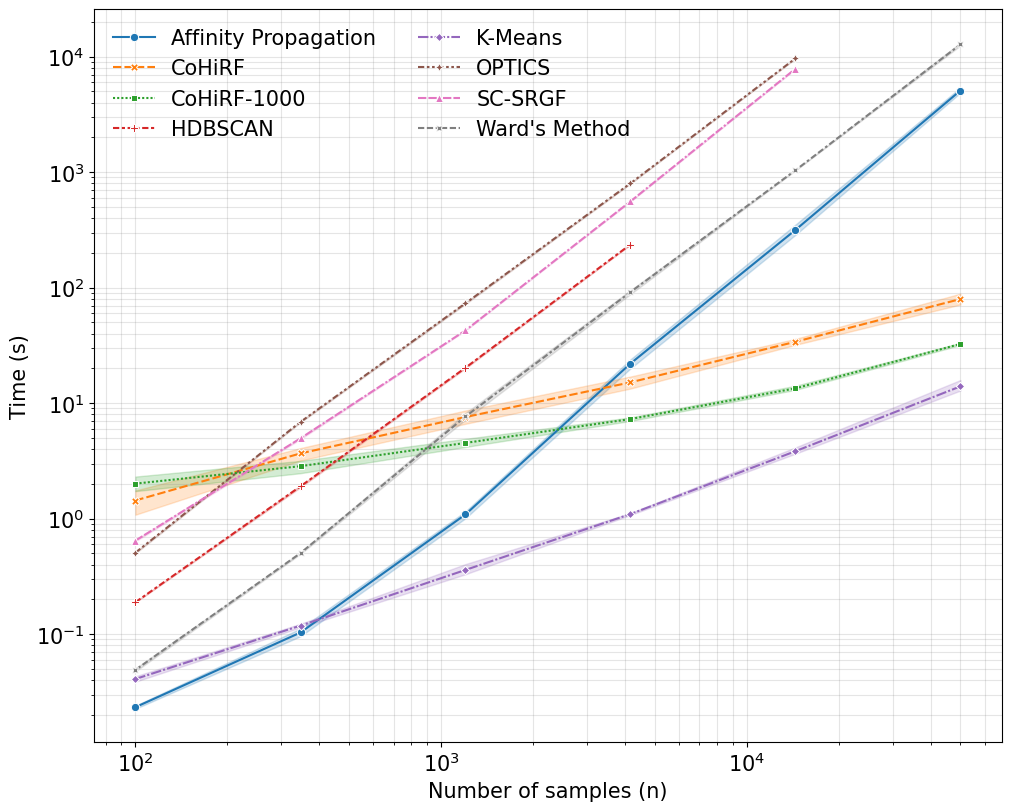

In [27]:
df = df_runs.copy()
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
n_features = 14427
n_samples = 14427
models_names = {
    'RecursiveClustering_': 'CoHiRF',
    'RecursiveClustering_closest_overall_1000': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.loc[df['model_nickname'].isin(['RecursiveClustering_','RecursiveClustering_closest_overall_1000', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples (n)', 'n_features': 'Number of features (p)', 'model_nickname': 'Model'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 8),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 15,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    # fig, axs = plt.subplots(1, 1)
    # axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features (p)']==n_features]
    # df_plot = df_plot.loc[df_plot['Number of samples (n)']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Number of samples (n)', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set grid
    ax.grid(True, which='both', color='gray', alpha=0.2)
    plt.legend(title=None, bbox_to_anchor=(0.0, 1.0), ncols=2)
    plt.savefig(results_dir / f'time_n-samples_n-features{n_features}_better.pdf')
        # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
    plt.show()

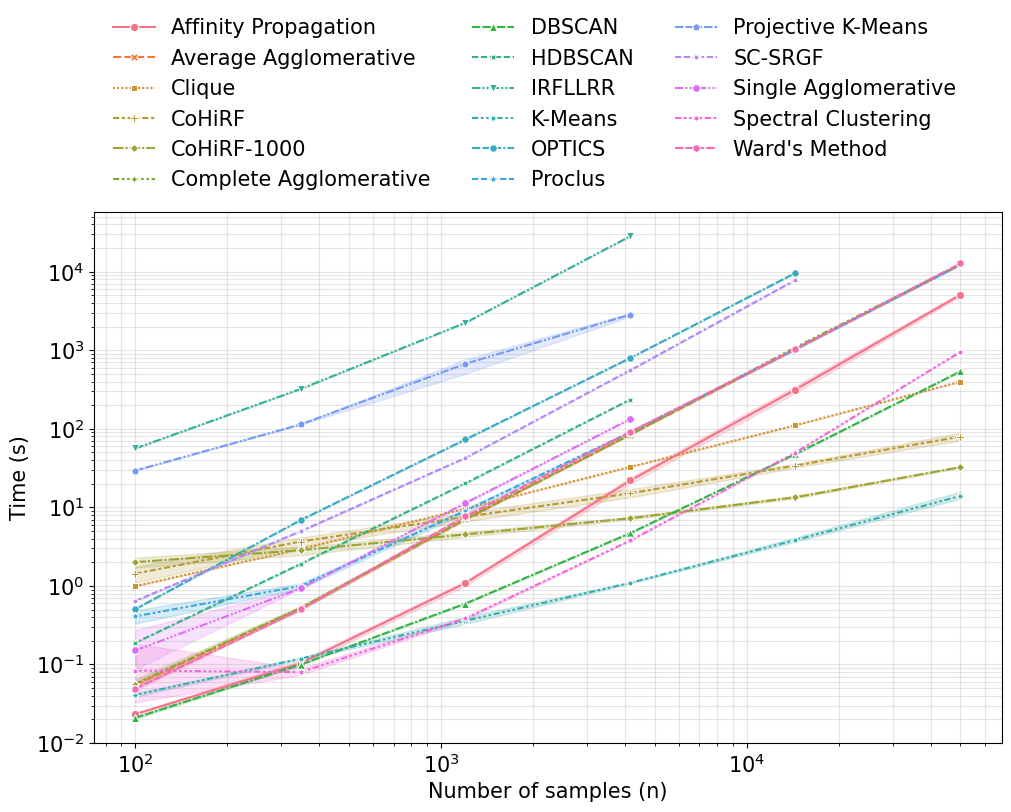

In [33]:
df = df_runs.copy()
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
n_features = 14427
n_samples = 14427
models_names = {
    'RecursiveClustering_': 'CoHiRF',
    'RecursiveClustering_closest_overall_1000': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
    'SpectralClustering': 'Spectral Clustering',
    'AverageAgglomerativeClustering': 'Average Agglomerative',
    'CompleteAgglomerativeClustering': 'Complete Agglomerative',
    'SingleAgglomerativeClustering': 'Single Agglomerative',
    'IRFLLRR': 'IRFLLRR',
    'Clique': 'Clique',
    'KMeansProj': 'Projective K-Means',
    'Proclus': 'Proclus',
}
# df = df.loc[df['model_nickname'].isin(['RecursiveClustering_','RecursiveClustering_closest_overall_1000', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples (n)', 'n_features': 'Number of features (p)', 'model_nickname': 'Model'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 8),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 15,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    # fig, axs = plt.subplots(1, 1)
    # axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features (p)']==n_features]
    # df_plot = df_plot.loc[df_plot['Number of samples (n)']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Number of samples (n)', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set grid
    ax.grid(True, which='both', color='gray', alpha=0.2)
    plt.legend(title=None, bbox_to_anchor=(0.0, 1.4), ncols=3)
    plt.savefig(results_dir / f'time_n-samples_n-features{n_features}_full.pdf')
        # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
    plt.show()

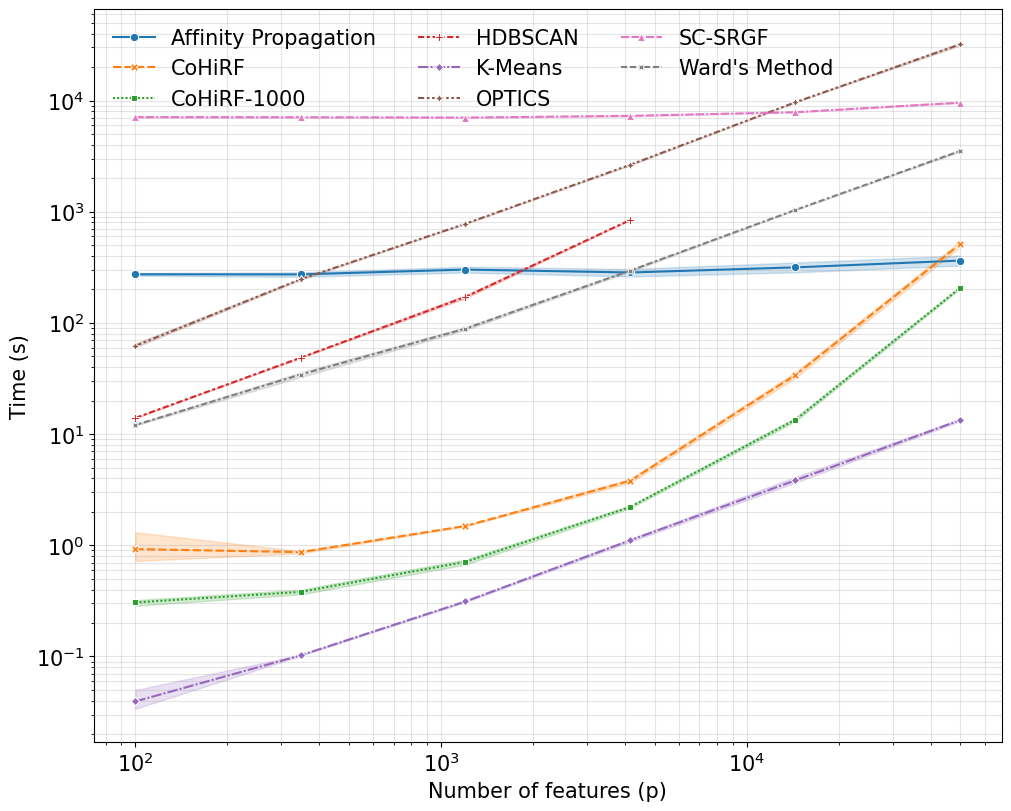

In [40]:
df = df_runs.copy()
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
n_features = 14427
n_samples = 14427
models_names = {
    'RecursiveClustering_': 'CoHiRF',
    'RecursiveClustering_closest_overall_1000': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.loc[df['model_nickname'].isin(['RecursiveClustering_','RecursiveClustering_closest_overall_1000', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples (n)', 'n_features': 'Number of features (p)', 'model_nickname': 'Model'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 8),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 15,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    # fig, axs = plt.subplots(1, 1)
    # axs = axs.flatten()
    df_plot = df.copy()
    # df_plot = df_plot.loc[df_plot['Number of features (p)']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples (n)']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Number of features (p)', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set grid
    ax.grid(True, which='both', color='gray', alpha=0.2)
    plt.legend(title=None, bbox_to_anchor=(0.0, 1.0), ncols=3)
    plt.savefig(results_dir / f'time_n-features_n-samples{n_samples}_better.pdf')
        # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
    plt.show()

In [42]:
df_plot.groupby(['Model', 'class_sep', 'n_classes', 'Number of samples (n)', 'Number of features (p)']).count()

status  \
Model                class_sep n_classes Number of samples (n) Number of features (p)           
Affinity Propagation 50.0      5         14427                 100                         10   
                                                               347                         10   
                                                               1202                        10   
                                                               4163                        10   
                                                               14427                       10   
                                                               50000                       10   
CoHiRF               50.0      5         14427                 100                         10   
                                                               347                         10   
                                                               1202                        10   
                                                               4163                        10   
                                                               14427                       10   
                                                               50000                       10   
CoHiRF-1000          50.0      5         14427                 100                         10   
                                                               347                         10   
                                                               1202                        10   
                                                               4163                        10   
                                                               14427                       10   
                                                               50000                       10   
HDBSCAN              50.0      5         14427                 100                          3   
                                                               347                          3   
                                                               1202                         3   
                                                               4163                         3   
K-Means              50.0      5         14427                 100                         10   
                                                               347                         10   
                                                               1202                        10   
                                                               4163                        10   
                                                               14427                       10   
                                                               50000                       10   
OPTICS               50.0      5         14427                 100                          3   
                                                               347                          3   
                                                               1202                         3   
                                                               4163                         3   
                                                               14427                        3   
                                                               50000                        3   
SC-SRGF              50.0      5         14427                 100                          6   
                                                               347                          3   
                                                               1202                         3   
                                                               4163                         3   
                                                               14427                        3   
                                                               50000                        3   
Ward's Method

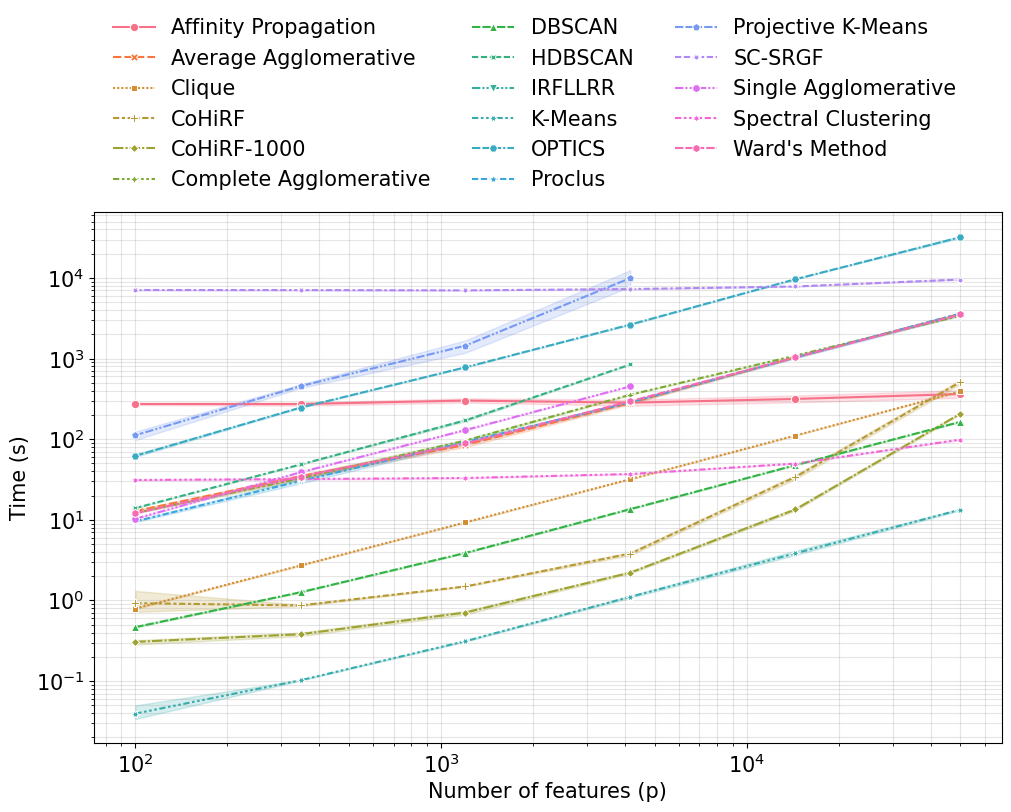

In [41]:
df = df_runs.copy()
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
n_features = 14427
n_samples = 14427
models_names = {
    'RecursiveClustering_': 'CoHiRF',
    'RecursiveClustering_closest_overall_1000': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
    'SpectralClustering': 'Spectral Clustering',
    'AverageAgglomerativeClustering': 'Average Agglomerative',
    'CompleteAgglomerativeClustering': 'Complete Agglomerative',
    'SingleAgglomerativeClustering': 'Single Agglomerative',
    'IRFLLRR': 'IRFLLRR',
    'Clique': 'Clique',
    'KMeansProj': 'Projective K-Means',
    'Proclus': 'Proclus',
}
# df = df.loc[df['model_nickname'].isin(['RecursiveClustering_','RecursiveClustering_closest_overall_1000', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples (n)', 'n_features': 'Number of features (p)', 'model_nickname': 'Model'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True,
    'savefig.bbox': 'tight',
    'figure.figsize': (10, 8),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 15,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    # fig, axs = plt.subplots(1, 1)
    # axs = axs.flatten()
    df_plot = df.copy()
    # df_plot = df_plot.loc[df_plot['Number of features (p)']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples (n)']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Number of features (p)', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set grid
    ax.grid(True, which='both', color='gray', alpha=0.2)
    plt.legend(title=None, bbox_to_anchor=(0.0, 1.4), ncols=3)
    plt.savefig(results_dir / f'time_n-features_n-samples{n_samples}_full.pdf')
        # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
    plt.show()

# Debug and explore

In [79]:
df = df_runs_raw.copy()
df = df.loc[df['status'] == 'FAILED']

In [78]:
df['EXCEPTION'].unique()

array(['Input X contains NaN.\nSpectralClustering does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values',
       'Empty cluster', 'FunctionTimedOut',
       'index 16 is out of bounds for axis 0 with size 16',
       'index 18 is out of bounds for axis 0 with size 18', nan,
       'SVD did not converge'], dtype=object)

In [42]:
df = df_runs_raw_parents.copy()
df = df.loc[df['status'] == 'FAILED']

In [43]:
df

key,status,start_time,end_time,class_sep,model_nickname,n_classes,n_features,n_informative,n_random,n_samples,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
01f490e163954c9b914d9f9f7765e075,FAILED,1737242580909,1.737260e+12,100.0,RecursiveClustering,5,10000,2,16,10000,...,3631.760,1.609438,7.0,0.920715,0.960011,0.336783,[Errno 28] No space left on device: '/tmp/ea30...,NaN,NaN,True
1185ab831bbc44d1966d666a207215c4,FAILED,1737242168108,1.737260e+12,10.0,RecursiveClustering,5,10000,2,16,10000,...,3345.972,0.793675,2202.0,0.177624,0.799918,-0.216621,RecursiveClustering_0_10000_16_2_10000_0.5_10....,NaN,NaN,True
12c09c8e4f834d15983dc3bdfcbc5959,FAILED,1737241068913,1.737242e+12,50.0,OPTICS,5,100,2,16,10000,...,426.124,NaN,NaN,NaN,NaN,NaN,"Every trial failed, no best model was found",NaN,NaN,True
183f2361e71047adae98f3a64c4174fd,FAILED,1736863645016,1.736865e+12,100.0,HDBSCAN,5,10000,2,16,10000,...,1037.448,NaN,NaN,NaN,NaN,NaN,HDBSCAN_0_10000_16_2_10000_0.7_100.0_0-19785e2...,NaN,NaN,True
27f9e72213b44c04bdb67ef7d2a0e693,FAILED,1737069296874,1.737070e+12,50.0,SpectralSubspaceRandomization,5,100,2,16,10000,...,1042.800,NaN,NaN,NaN,NaN,NaN,SpectralSubspaceRandomization_0_10000_16_2_100...,NaN,NaN,True
2ce22bf1a8c0477b8313a2c021926f17,FAILED,1737242600585,1.737260e+12,100.0,RecursiveClustering,5,10000,2,16,10000,...,3637.124,1.609438,5.0,1.000000,1.000000,0.555884,RecursiveClustering_0_10000_16_2_10000_0.5_100...,NaN,NaN,True
3457a0fa91564368ac3ae4164b12c70d,FAILED,1736863640977,1.736865e+12,10.0,HDBSCAN,5,10000,2,16,10000,...,1038.472,NaN,NaN,NaN,NaN,NaN,HDBSCAN_0_10000_16_2_10000_0.2_10.0_0-b2773806...,NaN,NaN,True
38e1e3deb33b46608f6a5b5b8f99da93,FAILED,1737113267664,1.737181e+12,50.0,SpectralSubspaceRandomization,5,10000,2,16,1000,...,2070.728,1.609438,5.0,1.000000,1.000000,0.401385,SpectralSubspaceRandomization_0_1000_16_2_1000...,NaN,NaN,True
3a54a04f81d0422ca859a7bab8881c8d,FAILED,1736863838482,1.736889e+12,10.0,SingleAgglomerativeClustering,5,10000,2,16,10000,...,1935.216,0.001932,13.0,0.002382,0.201360,0.078242,SingleAgglomerativeClustering_0_10000_16_2_100...,NaN,NaN,True


In [44]:
parent_run_ids = list(df.index)

In [45]:
parent_run_ids

['01f490e163954c9b914d9f9f7765e075',
 '1185ab831bbc44d1966d666a207215c4',
 '12c09c8e4f834d15983dc3bdfcbc5959',
 '183f2361e71047adae98f3a64c4174fd',
 '27f9e72213b44c04bdb67ef7d2a0e693',
 '2ce22bf1a8c0477b8313a2c021926f17',
 '3457a0fa91564368ac3ae4164b12c70d',
 '38e1e3deb33b46608f6a5b5b8f99da93',
 '3a54a04f81d0422ca859a7bab8881c8d',
 '4bb729150a4047e3936c0d62898d819f',
 '4bdc0a18868e4e9f998bf130711d2b23',
 '509a5f91adc24a559c551a67d3176b19',
 '56dfbd80504d4894b7f9346d94379352',
 '584d5567482a47a38b2365e42daaf666',
 '5bfa2e15da68491f91ef0e52658ded1a',
 '63f3db0d9768455891db79bf4f25cb9a',
 '6cb72b4cb1a7484fb07ccb762e2afa60',
 '728eeba9325144af81fcb3e61779f67c',
 '734c393283594d0580c681ee480ea77f',
 '83386e96e53347d6b0a94a650638ebe0',
 '87afb3a0102f478b9e93789ceb9c765b',
 '8f7ca2c7f3824f80895636f6e4ffc224',
 '91aef0d462cf41e98c8158b9a2cf3d60',
 'a509fded18e34b2db012ad900a8ea33d',
 'aa7a22cb6c2544a99f93fef9ad998812',
 'ac5535d9dab64e0984f05e4781878211',
 'ae9e3db12a3841b4a6b7d7cc99a8175e',
 

In [46]:
df = df_runs_raw.copy()
df = df.loc[df['parent_run_id'].isin(parent_run_ids)]

In [82]:
child_run_ids = list(df.index)

In [83]:
runs_to_delete = child_run_ids

In [84]:
print(runs_to_delete, len(runs_to_delete))

['0000c6d69e0f4e85b8d1650b58da14f2', '0000da5f9fc24a569b9ffb8b8432f437', '000206dcb44b4b91a3e4b9e14c6ca91d', '000235a40393424b9eec5ae38d3c5df9', '00027203bf6240759b5c94c2a71df7e2', '00049fb232ea4abcacd62d7fd1b9a984', '000b9da051974b9f9a629569bf067175', '000f3ca3f9ba4d0a9b0a2337d3acefb9', '0010a7237b3b4aa08ed0a5108b3aeac3', '0012082c59754f679754ad74e8770c03', '00139e746ec040a58d7b18bc45ec5b9b', '00199a61ac8049719568c2d2d3f3ef76', '001ded53b30142399200ae03e96dc164', '001f9f0c3804485ea40ddf7c648e1656', '002058b02b3a431fac0e2479a4819986', '0022adbe04484660af3908bfa5356221', '0024617690814b169201c319c7cc4b8f', '002599d25ba64c83a75d96fb6f8ef4ba', '002679b28ce4407ebaa5f4dd4d320feb', '0026de99ef744795b7debe8634055f65', '00289663864d47bd89a0f30684d3d0cf', '0030f0faf01943a6bb82d7739f1f0043', '00318479d22d425f9e63eef277a28167', '003646d80ffd4949bf7bf814f8ad6b6f', '00367ceaee50474b831ddf75a38ebf01', '003fab528dc64ac8ba585942a4fdb421', '00407135dda44c76ad763fa046180e05', '0041650e45e54ef8a33c302d1e

In [85]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [86]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    